## Ejemplo de análisis de datos: series y geolocalización.

Se van a utilizar datos obtenidos de la ciudad de Madrid en cuanto al clima y estaciones dedicadas para ello, y así ver el tratamiento que podemos dar a datos temporales y series, y también a datos geolocalizados para poder representar mapas y marcar puntos en ellos.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# imports necesarios
# no mostrar warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime
import random

!pip install folium
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import TimestampedGeoJson

!pip install vincent
import vincent

In [3]:
# funciones 

# función para cargar los datos en un dataframe y ver el tamaño y sus columnas/atributos
def cargar_datos(data):
    df = pd.read_csv('./'+data, sep=',')
    print("Dataset: num_rows: %d\tColumnas: %d\n" % (df.shape[0], df.shape[1]))
    print("columns:\n", list(df.columns))

    return df


# función para rellenar datos vacios del dataframe de datos temporales/series
def eliminar_nans(df):
    tipos = df.columns.to_series().groupby(df.dtypes).groups
    
    # Lista de columnas categóricas
    ctext = tipos[np.dtype('object')]
    # Lista de columnas numéricas
    columnas = df.columns 
    cnum = list(set(columnas) - set(ctext))

    # Completando valores faltantes de datos cuantitativos
    for c in cnum:
        mean = df[c].mean()
        df[c] = df[c].fillna(mean)
    
    # Completando valores faltantes de datos categóricos
    for c in ctext:
        df[c] = df[c].fillna('No Rain')
    
    return df


# función que en base a unas coordenadas genera otra cercana aleatoria
def generate_new_coordinates(coordenadas):
    latitud = coordenadas[0] 
    longitud = coordenadas[1]
    new_position = (latitud + random.uniform(0.00, 0.03), longitud + random.uniform(0.00, 0.03))
    
    return new_position
    

# función que añade marcadores al mapa, en base a unas coordenadas iniciales. Se le pasa la cantidad de
# marcadores a añadir al mapa.
def add_markers(cantidad, coordenadas, mapa):
    for i in range(0, cantidad):
        coordenadas_aux = generate_new_coordinates(coordenadas)
        folium.Marker(location=coordenadas_aux).add_to(mapa)


# función que añade un marcador a una lista de coordenadas
def add_markers_lista(lista_coordenadas, mapa, tooltip, popup):
    for i in range(0, len(lista_coordenadas)):
        coordenadas_aux = generate_new_coordinates(lista_coordenadas[i])
        folium.Marker(location=coordenadas_aux, tooltip=tooltip[i], popup=popup[i]).add_to(mapa)

#### 1. Tratamiento de datos temporales y series

Cargamos los datos del clima de Madrid entre 1997 y 2015. Estos datos vienen marcados por la fecha y pueden tratarse como series temporales e indexarse por la fecha.

In [4]:
# carga de los datos del clima en Madrid entre los años 1997 y 2015
df_clima_madrid = cargar_datos('weather_madrid_LEMD_1997_2015.csv')

Dataset: num_rows: 6812	Columnas: 23

columns:
 ['CET', 'Max TemperatureC', 'Mean TemperatureC', 'Min TemperatureC', 'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity', ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressurehPa', ' Mean Sea Level PressurehPa', ' Min Sea Level PressurehPa', ' Max VisibilityKm', ' Mean VisibilityKm', ' Min VisibilitykM', ' Max Wind SpeedKm/h', ' Mean Wind SpeedKm/h', ' Max Gust SpeedKm/h', 'Precipitationmm', ' CloudCover', ' Events', 'WindDirDegrees']


In [5]:
df_clima_madrid.head()

,CET,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1997-1-1,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,...,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229
1,1997-1-2,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,...,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143
2,1997-1-3,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,...,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256
3,1997-1-4,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,...,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284
4,1997-1-5,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,...,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2


In [6]:
# vamos a cargar los datos y quedarnos solo con la fecha para indexar los datos por este valor, y la temperatura
# media para hacer visualizaciones basadas en este atributo.
df_clima_meanC = pd.read_csv('./weather_madrid_LEMD_1997_2015.csv', sep=',', usecols=[0,2], parse_dates=[0],\
                    dtype=np.float64, dayfirst=True, index_col=0)

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_clima_meanC.shape[0], df_clima_meanC.shape[1]))
print("columns:\n", list(df_clima_meanC.columns))
df_clima_meanC.head()

Dataset: num_rows: 6812	Columnas: 1

columns:
 ['Mean TemperatureC']


,Mean TemperatureC
CET,
1997-01-01,4.0
1997-01-02,3.0
1997-01-03,3.0
1997-01-04,3.0
1997-01-05,0.0


In [7]:
# podemos ver las estadísticas básicas de la temperatura media
df_clima_meanC.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean TemperatureC,6809.0,14.658687,7.580461,-3.0,8.0,14.0,21.0,32.0


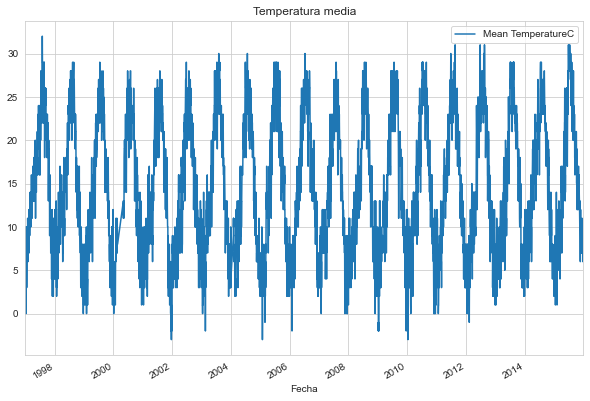

In [8]:
# pintamos la serie
plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
df_clima_meanC['Mean TemperatureC'].plot()
plt.legend()
plt.xlabel('Fecha')
plt.title('Temperatura media');

In [9]:
# al tener los datos indexados por fecha, se puede obtener otro dataframe a partir del inicial, indicando el
# rango de fechas. Aquí nos quedamos con los datos del año 2014 y 2015.
df_clima_2014_2015 = df_clima_meanC['2014-1':'2015-12']

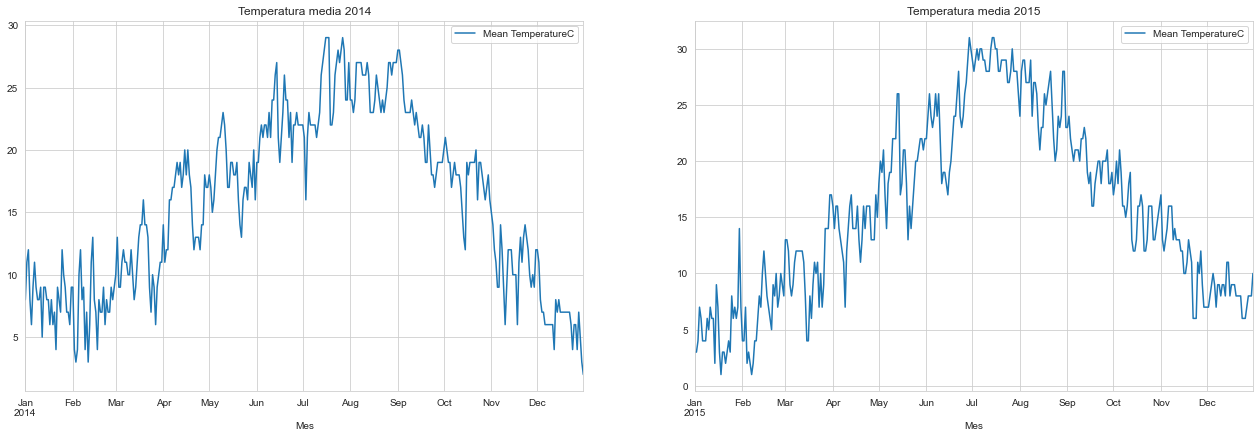

In [10]:
# visualizamos en dos gráficos los datos de 2014 y de 2015 para comparar los dos años
plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
df_clima_2014_2015['2014-01':'2014-12']['Mean TemperatureC'].plot()
plt.legend()
plt.xlabel('Mes')
plt.title('Temperatura media 2014')

plt.subplot(2,2,2)
df_clima_2014_2015['2015-01':'2015-12']['Mean TemperatureC'].plot()
plt.legend()
plt.xlabel('Mes')
plt.title('Temperatura media 2015');

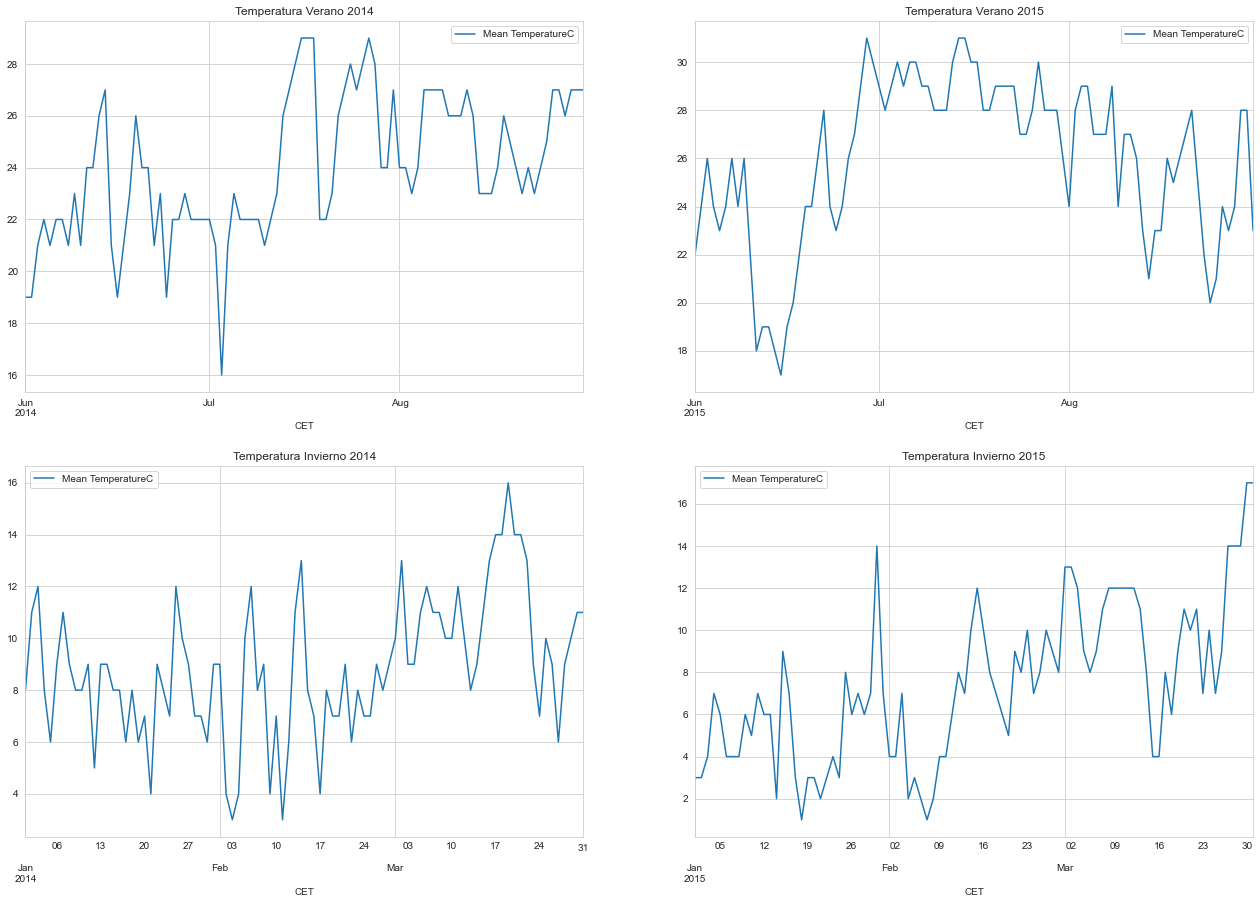

In [11]:
# pintamos un intervalo de 2 meses tanto de 2014 como de 2015, para ver valores en verano e invierno y compararlos
# donde obviamente se aprecia como los valores en cada año son similares, ya que por lógica la temperatura media
# es mayor en los meses de verano, ya que es algo con bastante estacionalidad.
warnings.filterwarnings('ignore')

plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
df_clima_2014_2015['2014-06':'2014-08']['Mean TemperatureC'].plot()
plt.legend()
plt.title('Temperatura Verano 2014')

plt.subplot(2,2,2)
df_clima_2014_2015['2015-06':'2015-08']['Mean TemperatureC'].plot()
plt.legend()
plt.title('Temperatura Verano 2015')

plt.subplot(2,2,3)
df_clima_2014_2015['2014-01':'2014-03']['Mean TemperatureC'].plot()
plt.legend()
plt.title('Temperatura Invierno 2014')

plt.subplot(2,2,4)
df_clima_2014_2015['2015-01':'2015-03']['Mean TemperatureC'].plot()
plt.legend()
plt.title('Temperatura Invierno 2015');

In [12]:
# los datos de series pueden tener algún hueco o vacío, usamos el siguiente método donde si obtenemos True
# es que tenemos huecos y debemos rellenarlos
df_clima_meanC.isna().any()

Mean TemperatureC    True
dtype: bool

In [13]:
# como se han visto huecos, se usa el método interpolate para rellenar los huecos. 
# luego volvemos a usar el método anterior y ya no hay huecos.
df_clima_meanC_int = df_clima_meanC.interpolate(method='linear', axis=0, limit=None, inplace=False,\
                        limit_direction='forward', limit_area=None, downcast=None)

print("num_rows: %d\tColumnas: %d\n" % (df_clima_meanC_int.shape[0], df_clima_meanC_int.shape[1]) )
print("\n")
print(df_clima_meanC_int.isna().any())

num_rows: 6812	Columnas: 1



Mean TemperatureC    False
dtype: bool


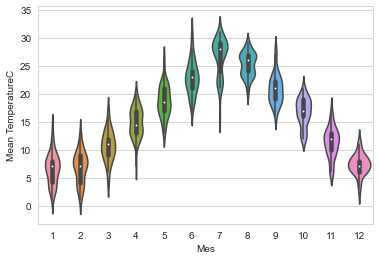

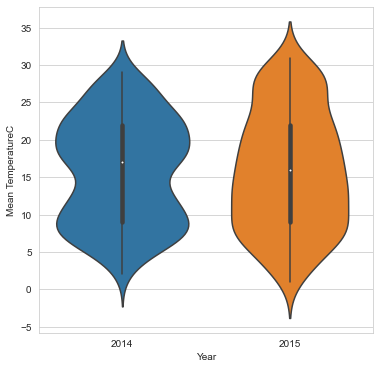

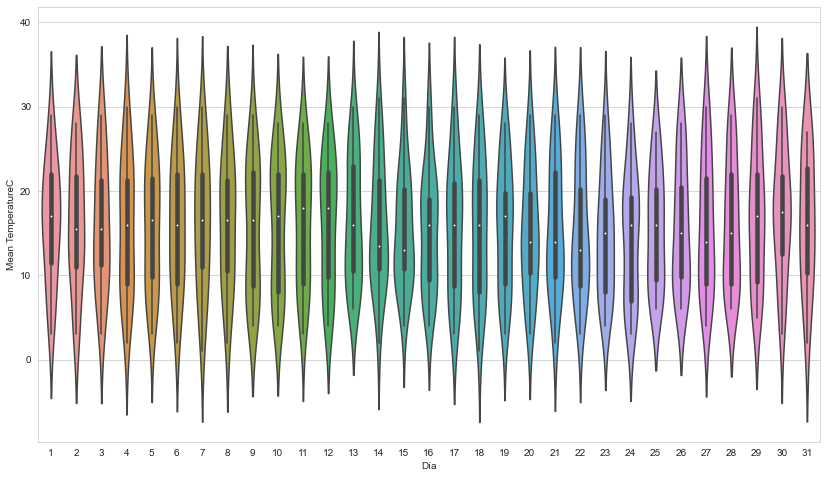

In [14]:
# se pueden ver las distribuciones de los datos con otro tipo de gráficos, y verse por año, mes o día
plt.figure(figsize=(6,4)); 
sns.violinplot(x=df_clima_2014_2015.index.month, y=df_clima_2014_2015['Mean TemperatureC']); 
plt.xlabel('Mes')
plt.show()

plt.figure(figsize=(6,6)); 
sns.violinplot(x=df_clima_2014_2015.index.year, y=df_clima_2014_2015['Mean TemperatureC']); 
plt.xlabel('Year')
plt.show()

plt.figure(figsize=(14,8)); 
sns.violinplot(x=df_clima_2014_2015.index.day, y=df_clima_2014_2015['Mean TemperatureC']); 
plt.xlabel('Día')
plt.show()

In [15]:
# volvemos a cargar los datos y añadimos alguna columna mas al dataframe para hacer otro tipo de visualizaciones
df_clima_meanC_2 = pd.read_csv('./weather_madrid_LEMD_1997_2015.csv',sep=',',usecols=[0,1,2,3,21],parse_dates=[0],\
                    dayfirst=True)

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_clima_meanC_2.shape[0], df_clima_meanC_2.shape[1]))
print("columns:\n", list(df_clima_meanC_2.columns))

Dataset: num_rows: 6812	Columnas: 5

columns:
 ['CET', 'Max TemperatureC', 'Mean TemperatureC', 'Min TemperatureC', ' Events']


In [16]:
# preparamos el dataframe: eliminamos los huecos o vacíos, rellenando los atributos numéricos con la media de ese
# atributo, y los categóricos que en este caso son el evento del día (si llueve, tormenta, etc)
df_clima_meanC_2 = eliminar_nans(df_clima_meanC_2)

# renombramos la columna " Events" que se aprecia al cargar los datos que viene con un espacio.
df_clima_meanC_2 = df_clima_meanC_2.rename(columns={' Events':'Events'})

In [17]:
# también cogemos el atributo de la fecha y generamos otros tres atributos para separar año, mes y día
df_clima_meanC_2["CET"] = pd.to_datetime(df_clima_meanC_2["CET"]).dt.date

df_clima_meanC_2['year'] = pd.to_datetime(df_clima_meanC_2["CET"]).dt.year
df_clima_meanC_2['month'] = pd.to_datetime(df_clima_meanC_2["CET"]).dt.month
df_clima_meanC_2['day'] = pd.to_datetime(df_clima_meanC_2["CET"]).dt.day

df_clima_meanC_2.head()

,CET,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Events,year,month,day
0,1997-01-01,7.0,4.0,2.0,No Rain,1997,1,1
1,1997-01-02,7.0,3.0,0.0,Rain,1997,1,2
2,1997-01-03,5.0,3.0,2.0,Rain-Snow,1997,1,3
3,1997-01-04,7.0,3.0,-1.0,No Rain,1997,1,4
4,1997-01-05,2.0,0.0,-1.0,Snow,1997,1,5


In [18]:
# nos quedamos con los datos del año 2015
df_clima_meanC_2_2015 = df_clima_meanC_2[df_clima_meanC_2.year == 2015]

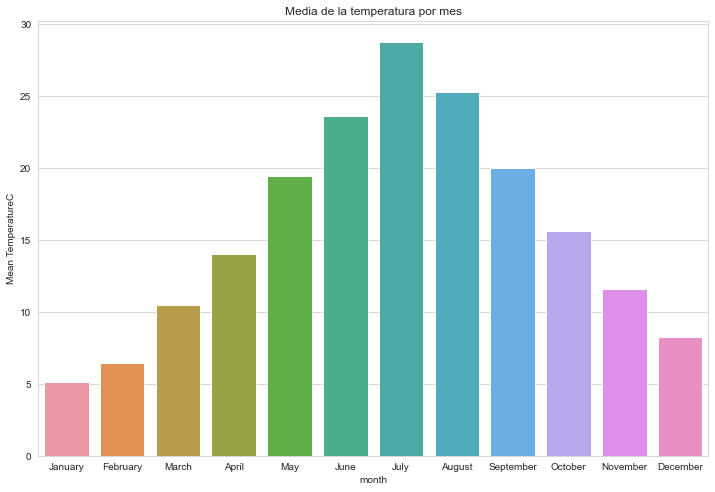

In [19]:
# mostramos la Media de la temperatura por mes:
months = ["January","February","March","April","May","June","July","August","September","October",\
          "November","December"]
month_count=pd.DataFrame(df_clima_meanC_2_2015.groupby("month")["Mean TemperatureC"].mean()).reset_index()

plt.figure(figsize=(12, 8))
_ = sns.barplot(data=month_count,x="month",y="Mean TemperatureC",label=months)
plt.xticks(np.arange(0,12),months)
plt.title("Media de la temperatura por mes");

In [20]:
# vemos los distintos valores que hay en el atributo Events
pd.value_counts(df_clima_meanC_2_2015['Events'])

No Rain              284
Rain                  48
Fog                   12
Rain-Thunderstorm     12
Fog-Rain               4
Rain-Snow              3
Snow                   1
Rain-Hail              1
Name: Events, dtype: int64

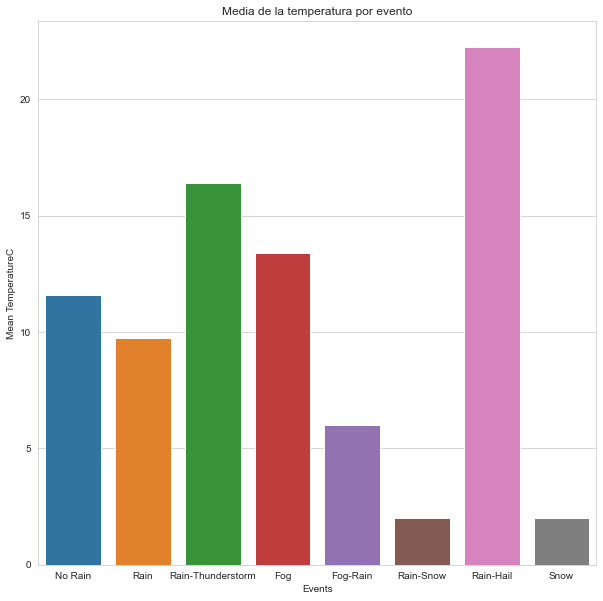

In [21]:
# Media de la temperatura por tipo de evento
eventos = ["No Rain","Rain","Rain-Thunderstorm","Fog","Fog-Rain","Rain-Snow","Rain-Hail","Snow"]
eventos_count=pd.DataFrame(df_clima_meanC_2_2015.groupby("Events")["Mean TemperatureC"].mean()).reset_index()

plt.figure(figsize=(10, 10))
_ = sns.barplot(data=eventos_count,x="Events",y="Mean TemperatureC",label=eventos)
plt.xticks(np.arange(0,8),eventos)
plt.title("Media de la temperatura por evento");

#### 2. Trabajo con datos geolocalizados.

Ahora vamos a usar algunas librerías para hacer visualizaciones y análisis de datos que tengan atributos que indiquen su geolocalización, y así poder pintar mapas.

In [22]:
# ejemplo de visualización de un mapa con uso de folium. Utilizamos las coordenadas de Madrid
madrid_coordinates = (40.416709, -3.703492)

# según el valor de zoom que pongamos se cargará el mapa con mayor o menor cercanía
madrid = folium.Map(location=madrid_coordinates,zoom_start=12,tiles="OpenStreetMap")
# objeto mapa
madrid

In [23]:
# sobre el mapa anterior de Madrid, añadimos marcadores de forma aleatoria, introducimos otro marcador con
# mensaje tanto como tooltip como al pinchar sobre el marcador. Además también probamos a añadir otro tipo
# de marcador y con otro color.

# añadir 5 marcadores aleatoriamente
add_markers(5, madrid_coordinates, madrid)

# añadir marcadores con mensajes
folium.Marker(location=madrid_coordinates, tooltip=folium.Tooltip("Mensaje tooltip"),\
              popup='Centro de Madrid').add_to(madrid)

folium.Marker(location=generate_new_coordinates(madrid_coordinates), tooltip=folium.Tooltip('Marcador rojo'),\
              popup="Marcador de color rojo", icon=folium.Icon(color='red')).add_to(madrid)

madrid

In [24]:
# también podemos pintar un circulo radial sobre las coordenadas que pasemos
folium.CircleMarker(location=madrid_coordinates, radius=100, popup='Madrid Central', color='blue',
                    fill=True, fill_color='blue').add_to(madrid)

madrid

In [25]:
# marcando unos puntos como vértices se puede también dibujar un polígono sobre el mapa
points = [[40.422762, -3.680327], [40.428128, -3.668718], [40.445953, -3.686382], [40.446737, -3.704063],
           [40.442132, -3.704106], [40.441279, -3.691940], [40.422762, -3.680327]]

folium.PolyLine(locations=points, color='green',
                popup=folium.Popup(u"Área delimitada con líneas", parse_html=True)).add_to(madrid)

folium.LayerControl().add_to(madrid)

madrid

In [26]:
# utilizando GeoJson y pasando las coordenadas dibujamos un área delimitada en el mapa, en este caso
# mostramos los límites de Madrid Central.
madrid_central = folium.Map(location=madrid_coordinates, tiles='OpenStreetMap', zoom_start=14)

geojson_madrid_central = folium.GeoJson(
    data = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[[-3.711305, 40.406807],[-3.702612, 40.404997],[-3.693235, 40.407742],
                [-3.692248, 40.409000],[-3.694617, 40.415505],[-3.690392, 40.424887],[-3.696207, 40.427856],
                [-3.702162, 40.429122],[-3.705810, 40.429681],[-3.714018, 40.430404],[-3.715059, 40.428918],
                [-3.711797, 40.424377],[-3.714372, 40.422988],[-3.712870, 40.421534],[-3.714029, 40.410539]]]}
    }, name = "Madrid Central")

geojson_madrid_central.add_child(folium.Popup('Madrid Central'),folium.Tooltip('Madrid Central'))
geojson_madrid_central.add_to(madrid_central)
folium.LayerControl().add_to(madrid_central)

madrid_central

In [27]:
# otro ejemplo de mapas que podemos formar con la librería sería mostrar un mapa dual, que pueden tener
# diferente visualización, y además podemos mostrar marcadores que con se pueden ocultar y mostrar con un
# control en el propio mapa.
madrid_dual = folium.plugins.DualMap(location=madrid_coordinates, tiles=None, zoom_start=11)

folium.TileLayer('openstreetmap').add_to(madrid_dual.m1)
folium.TileLayer('cartodbpositron').add_to(madrid_dual.m2)

fg_both = folium.FeatureGroup(name='markers_both').add_to(madrid_dual)
fg_1 = folium.FeatureGroup(name='markers_1').add_to(madrid_dual.m1)
fg_2 = folium.FeatureGroup(name='markers_2').add_to(madrid_dual.m2)

icon_red = folium.Icon(color='red')
folium.Marker(madrid_coordinates, tooltip='both', icon=icon_red).add_to(fg_both)
folium.Marker(madrid_coordinates, tooltip='1').add_to(fg_1)
folium.Marker(madrid_coordinates, tooltip='2').add_to(fg_2)

# control en el mapa para poder ocultar/mostrar marcadores e información
folium.LayerControl(collapsed=False).add_to(madrid_dual)

madrid_dual

Después de ver ejemplos del uso de la librería, cargamos unos datasets con datos del coronavirus, en el mundo y con datos de confirmados/recuperados/muertes por país.

In [28]:
# carga de datos
df_covid19 = pd.read_csv('./03-28-2020_covid19.csv',sep=',')

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_covid19.shape[0], df_covid19.shape[1]))
print("columns:\n", list(df_covid19.columns))
print('\n')
df_covid19.head()

Dataset: num_rows: 3430	Columnas: 12

columns:
 ['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key']




,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-28 23:05:37,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-28 23:05:37,30.295065,-92.414197,9,1,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-28 23:05:37,37.767072,-75.632346,2,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-28 23:05:37,43.452658,-116.241552,76,0,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-28 23:05:37,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


In [29]:
# preparación del dataframe
# eliminamos columnas que no queramos tener en cuenta
df_covid19 = df_covid19.drop(columns=['FIPS','Combined_Key'])
df_covid19 = df_covid19.rename(columns={'Long_':'Lon', 'Admin2':'Ciudad'})

df_covid19.head()

,Ciudad,Province_State,Country_Region,Last_Update,Lat,Lon,Confirmed,Deaths,Recovered,Active
0,Abbeville,South Carolina,US,2020-03-28 23:05:37,34.223334,-82.461707,3,0,0,0
1,Acadia,Louisiana,US,2020-03-28 23:05:37,30.295065,-92.414197,9,1,0,0
2,Accomack,Virginia,US,2020-03-28 23:05:37,37.767072,-75.632346,2,0,0,0
3,Ada,Idaho,US,2020-03-28 23:05:37,43.452658,-116.241552,76,0,0,0
4,Adair,Iowa,US,2020-03-28 23:05:37,41.330756,-94.471059,1,0,0,0


In [31]:
# nos vamos a quedar con los datos de EEUU que vienen por población (el resto de paises viene el conjunto del
# pais).
# Vamos a separar en un dataframe los datos de confirmados y en otro de muertes.
df_usa_confirmed = df_covid19[(df_covid19['Country_Region']=='US') & (df_covid19['Confirmed']>0)]
df_usa_deaths = df_covid19[(df_covid19['Country_Region']=='US') & (df_covid19['Deaths']>0)]

df_usa_confirmed = df_usa_confirmed.drop_duplicates(subset=['Lat','Lon'], keep='last')
df_usa_deaths = df_usa_deaths.drop_duplicates(subset=['Lat','Lon'], keep='last')

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_usa_confirmed.shape[0], df_usa_confirmed.shape[1]))
print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_usa_deaths.shape[0], df_usa_deaths.shape[1]))

Dataset: num_rows: 1846	Columnas: 10

Dataset: num_rows: 354	Columnas: 10



In [32]:
# obtenemos listas de coordenadas para luego pintar en los mapas un marcador en cada ciudad/población donde
# haya habido confirmaciones y donde haya habido alguna muerte.
lista_coordenadas_deaths = []
lista_coordenadas_confirmed = []

lista_lat_death = list(df_usa_deaths['Lat'].unique())
lista_lon_death = list(df_usa_deaths['Lon'].unique())
lista_lat_conf = list(df_usa_confirmed['Lat'].unique())
lista_lon_conf = list(df_usa_confirmed['Lon'].unique())
lista_deaths = list(df_usa_deaths['Deaths'])
lista_confirmed = list(df_usa_confirmed['Confirmed'])
lista_ciudades_deaths = list(df_usa_deaths['Ciudad'])
lista_ciudades_confirmed = list(df_usa_confirmed['Ciudad'])

for i in range(0, len(lista_lat_death)):
    lista_coordenadas_deaths.append([lista_lat_death[i],lista_lon_death[i]])
    
for i in range(0, len(lista_lat_conf)):
    lista_coordenadas_confirmed.append([lista_lat_conf[i],lista_lon_conf[i]])

In [33]:
# pintamos en un mapa dual todos los casos de EEUU por población. Arriba las confirmaciones, y abajo las muertes.
# poniendo el cursor sobre un marcador sale un mensaje con la población, y pinchando en el marcado saldrá el 
# número de confirmados/muertes respectivamente.
coordinates = (34.223334, -82.461707)

usa_dual = folium.plugins.DualMap(location=coordinates, tiles=None, zoom_start=3, layout='vertical')

folium.TileLayer('openstreetmap').add_to(usa_dual.m1)
folium.TileLayer('cartodbpositron').add_to(usa_dual.m2)

add_markers_lista(lista_coordenadas_confirmed, usa_dual.m1, lista_ciudades_confirmed, lista_confirmed)
add_markers_lista(lista_coordenadas_deaths, usa_dual.m2, lista_ciudades_deaths, lista_deaths)

# objeto mapa
usa_dual

Ahora cargamos unos datos con la información por país, y además donde hay un registro por cada día desde que comenzó la pandemia, así puede verse la evolución en un país en cuestión.

In [34]:
# carga de datos
df_covid19_geo = pd.read_csv('./series_diaria_covid19_geolocalizado.csv',sep=',')

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_covid19_geo.shape[0], df_covid19_geo.shape[1]))
print("columns:\n", list(df_covid19_geo.columns))
print('\n')
df_covid19_geo.head()

Dataset: num_rows: 16951	Columnas: 8

columns:
 ['Date', 'Country/Region', 'Province/State', 'Lat', 'Long', 'Confirmed', 'Recovered', 'Deaths']




,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0,0.0,0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0,0.0,0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0,0.0,0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0,0.0,0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0,0.0,0


In [35]:
# nos quedamos con los registros de España
df_spain = df_covid19_geo[df_covid19_geo['Country/Region']=='Spain']

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_spain.shape[0], df_spain.shape[1]))
print("columns:\n", list(df_spain.columns))
print('\n')

df_spain.head()

Dataset: num_rows: 67	Columnas: 8

columns:
 ['Date', 'Country/Region', 'Province/State', 'Lat', 'Long', 'Confirmed', 'Recovered', 'Deaths']




,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
13467,2020-01-22,Spain,NaN,40.0,-4.0,0,0.0,0
13468,2020-01-23,Spain,NaN,40.0,-4.0,0,0.0,0
13469,2020-01-24,Spain,NaN,40.0,-4.0,0,0.0,0
13470,2020-01-25,Spain,NaN,40.0,-4.0,0,0.0,0
13471,2020-01-26,Spain,NaN,40.0,-4.0,0,0.0,0


In [36]:
# el campo de la fecha/hora lo pasamos a fecha y generamos 3 atributos de año, mes y día
df_spain["Last_Update"] = pd.to_datetime(df_spain["Date"]).dt.date
df_spain['year'] = pd.to_datetime(df_spain["Date"]).dt.year
df_spain['month'] = pd.to_datetime(df_spain["Date"]).dt.month
df_spain['day'] = pd.to_datetime(df_spain["Date"]).dt.day

# nos quedamos con los datos de Marzo
df_spain_marzo = df_spain[df_spain['month']==3]

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_spain_marzo.shape[0], df_spain_marzo.shape[1]))
print('\n')

df_spain_marzo.head()

Dataset: num_rows: 28	Columnas: 12





,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,Last_Update,year,month,day
13506,2020-03-01,Spain,NaN,40.0,-4.0,84,2.0,0,2020-03-01,2020,3,1
13507,2020-03-02,Spain,NaN,40.0,-4.0,120,2.0,0,2020-03-02,2020,3,2
13508,2020-03-03,Spain,NaN,40.0,-4.0,165,2.0,1,2020-03-03,2020,3,3
13509,2020-03-04,Spain,NaN,40.0,-4.0,222,2.0,2,2020-03-04,2020,3,4
13510,2020-03-05,Spain,NaN,40.0,-4.0,259,2.0,3,2020-03-05,2020,3,5


In [37]:
# pintamos el mapa con las coordenadas iniciales de Madrid, y en el marcador que se pinta en Madrid si se pincha 
# sobre él veremos un gráfico donde aparece la evolución de confirmaciones durante el mes de Marzo.
xy_values = {'x': list(df_spain_marzo['day']), 'y': list(df_spain_marzo['Confirmed'])}

scatter_chart = vincent.Scatter(xy_values, iter_idx='x', width=800, height=300)
scatter_chart.axis_titles(x='Aumento diario de confirmados',y='')

popup_scatter_plot = folium.Popup(max_width=900).add_child(folium.Vega(scatter_chart, height=400, width=900))

madrid_coordinates = (40.416709, -3.703492)

# según el valor de zoom que pongamos se cargará el mapa con mayor o menor cercanía
madrid = folium.Map(location=madrid_coordinates,zoom_start=12,tiles="OpenStreetMap")

folium.Marker(location=madrid_coordinates, tooltip='Madrid', popup=popup_scatter_plot,
              icon=folium.Icon(color='red')).add_to(madrid)

madrid